# サンプルコード

## 準備まとめ

ダウンロードとインストール

In [1]:
!git clone https://github.com/ghmagazine/python_stat_sample.git
!mv ./python_stat_sample/data ./data
!pip install japanize-matplotlib

Cloning into 'python_stat_sample'...
remote: Enumerating objects: 130, done.
remote: Total 130 (delta 0), reused 0 (delta 0), pack-reused 130
Receiving objects: 100% (130/130), 8.22 MiB | 37.10 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 27.3 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=d8bce6992ab79ac71e4a9b056dd439aff030426992b079a5455d4c59725e5f5e
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


インポートと設定

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import comb
from scipy.special import factorial
from scipy import integrate
from scipy import optimize
from functools import partial

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=integrate.IntegrationWarning)

%precision 3
pd.set_option('precision', 3)
pd.options.display.float_format = '{:.3f}'.format

## おさらい

サイコロの確率関数と確率分布

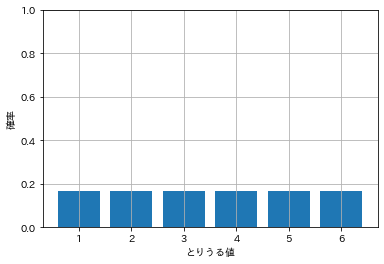

In [ ]:
def dice_prob_func(x):
    return 1 / 6

dice_x_set = [1, 2, 3, 4, 5, 6]
dice_prob = np.array([dice_prob_func(x) for x in dice_x_set])

plt.bar(dice_x_set, dice_prob)
plt.ylim(0.0, 1.0)
plt.xlabel('とりうる値')
plt.ylabel('確率')
plt.grid(True)
plt.show()

度数分布による確率分布の推定

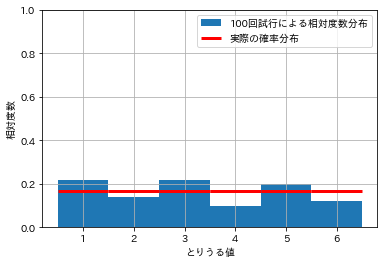

In [ ]:
num_trial = 100
dice_sample = np.random.choice(dice_x_set, num_trial)

plt.hist(
    dice_sample, bins=len(dice_x_set), range=(1, 7), density=True,
    label=f'{num_trial}回試行による相対度数分布')
plt.hlines(
    dice_prob, np.arange(1, 7), np.arange(2, 8),
    color='red', lw=3, label='実際の確率分布')

plt.xticks(np.linspace(1.5, 6.5, 6), labels=np.arange(1, 7))
plt.ylim(0.0, 1.0)
plt.xlabel('とりうる値')
plt.ylabel('相対度数')
plt.legend()
plt.grid(True)
plt.show()

## 代表的な離散型確率分布

### 準備

期待値と分散の関数

In [ ]:
def E(X, g=lambda x: x):
    x_set, f = X

    return np.sum([g(k) * f(k) for k in x_set])

def V(X, g=lambda x: x):
    x_set, f = X
    
    mean = E(X, g)
    return np.sum([(g(k) - mean) ** 2 * f(k) for k in x_set])

確率変数の性質の確認・表示

In [ ]:
def check_prob(X):
    x_set, f = X

    prob = np.array([f(k) for k in x_set])
    assert np.all(prob >= 0), '負の確率があります'

    prob_sum = np.round(np.sum(prob), 6)
    assert prob_sum == 1, f'確率の和が{prob_sum}になりました'

    print(f'期待値: {E(X):.4}, 分散: {V(X):.4}')

def plot_prob(X, size=(10, 6)):
    x_set, f = X

    prob = np.array([f(k) for k in x_set])
    e = E(X)

    plt.figure(figsize=size)
    plt.bar(x_set, prob, label='確率')
    plt.vlines(e, 0, 1, label='期待値', color='red')
    plt.xticks(np.append(x_set, e))
    plt.ylim(0, prob.max() * 1.2)
    plt.legend()
    plt.grid(True)
    plt.show()

### ベルヌーイ分布

#### NumPyによる実装

ベルヌーイ分布の確率関数

In [ ]:
def prob_bernoulli(x, p, x_set):
    if x in x_set:
        return (p ** x) * ((1 - p) ** (1 - x))
    else:
        return 0

サイコロで6が出るか，の確率分布

In [ ]:
bern_x_set = np.array([0, 1])
bern_p = 0.2

bern_prob = np.array(
    [prob_bernoulli(k, bern_p, bern_x_set) for k in bern_x_set])
pd.DataFrame(
    bern_prob, columns=['確率'], index=pd.Index(bern_x_set, name='とりうる値'))

,確率
とりうる値,
0,0.800
1,0.200


ベルヌーイ分布の確率変数を返す関数

In [ ]:
def Bern(p):
    x_set = np.array([0, 1])

    def f(x):
        if x in x_set:
            return (p ** x) * ((1 - p) ** (1 - x))
        else:
            return 0
    
    return x_set, f

確率変数の性質の確認

In [ ]:
p = 0.2
X = Bern(p)

check_prob(X)

期待値: 0.2, 分散: 0.16


確率変数の図示

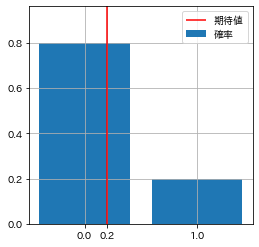

In [ ]:
plot_prob(X, size=(4, 4))

#### SciPyによる実装

SciPyでベルヌーイ分布に従う確率変数を返す

In [ ]:
rv = stats.bernoulli(p)
rv

確率関数

In [ ]:
rv.pmf(0), rv.pmf(1)

(0.8, 0.2)

確率関数にリストを渡す

In [ ]:
rv.pmf([0, 1])

array([0.8, 0.2])

累積密度関数

In [ ]:
rv.cdf([0, 1])

array([0.8, 1. ])

期待値，分散

In [ ]:
print(f'期待値:{rv.mean():.3f} 分散:{rv.var():.3f}')

期待値:0.200 分散:0.160


### 二項分布

#### NumPyによる実装

二項分布の確率変数を返す関数

In [ ]:
from scipy.special import comb

def Bin(n, p):
    x_set = np.arange(n + 1)
    
    def f(x):
        if x in x_set:
            return comb(n, x) * (p ** x) * ((1 - p) ** (n - x))
        else:
            return 0
        return x_set, f
    
    return x_set, f

コインを`3`回投げたとき表が出る回数の確率分布

In [ ]:
n = 3
p = 0.5
X = Bin(n, p)

x_set, bin = X
pd.DataFrame(
    [bin(x) for x in x_set],
    index=pd.Index(x_set, name='表が出る回数'),
    columns=['確率']).T

表が出る回数,0,1,2,3
確率,0.125,0.375,0.375,0.125


サイコロを`10`回投げたとき`6`が出る回数の確率分布

In [ ]:
n = 10
p = 1/6
X = Bin(n, p)

x_set, bin = X
prob = pd.DataFrame(
    [bin(x) for x in x_set],
    index=pd.Index(x_set, name='6が出る回数'),
    columns=['確率'])
prob.T

6が出る回数,0,1,2,3,4,5,6,7,8,9,10
確率,0.162,0.323,0.291,0.155,0.054,0.013,0.002,0.000,0.000,0.000,0.000


期待値と分散

In [ ]:
check_prob(X)

期待値: 1.667, 分散: 1.389


確率分布と期待値の図示

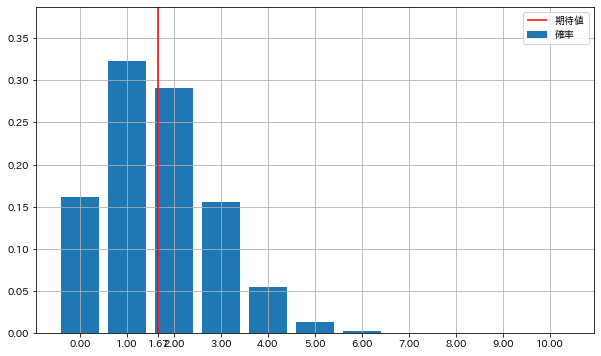

In [ ]:
plot_prob(X)

3回以上成功する確率の算出

In [ ]:
prob[prob.index >= 3].sum()

確率   0.225
dtype: float64

#### SciPyによる実装

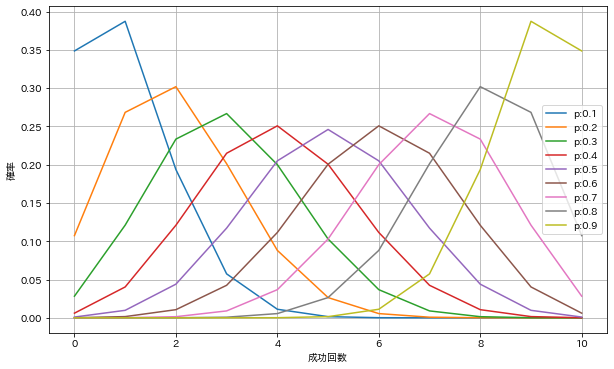

In [ ]:
n = 10
x_set = np.arange(n + 1)

plt.figure(figsize=(10, 6))
for i in range(1, 10):
    p = i / 10
    
    rv = stats.binom(n, p)
    prob = rv.pmf(x_set)

    plt.plot(x_set, prob, label=f'p:{p}')
plt.grid(True)
plt.xlabel('成功回数')
plt.ylabel('確率')
plt.legend()
plt.show()

#### 使いどころ

内定社数

期待値: 1.5, 分散: 1.275


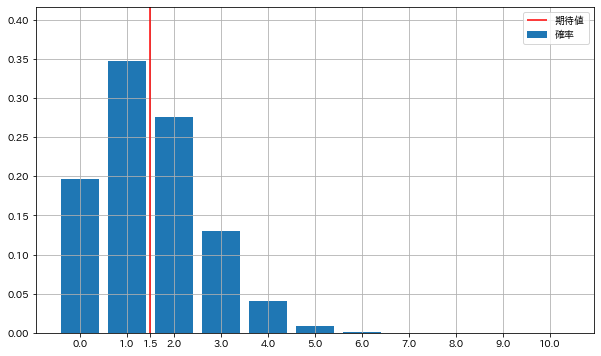

In [ ]:
X = Bin(0.15, 10)

check_prob(X)
plot_prob(X)

内定が2社以上得られる確率

In [ ]:
x_set, bin = X
prob = [bin(x) for x in x_set[x_set >= 2]]
np.sum(prob)

0.45570017623447245


### 幾何分布

#### NumPyによる実装

幾何分布の確率変数

In [ ]:
def Ge(p, x_max):
    x_set = np.arange(1, x_max + 1)
    
    def f(x):
        if x in x_set:
            return p * ((1 - p) ** (x - 1))
        else:
            return 0
    return x_set, f

エラーになる引数..

In [ ]:
X = Ge(0.1, x_max=100)
check_prob(X)

AssertionError: ignored

幾何分布の性質

期待値: 5.0, 分散: 20.0


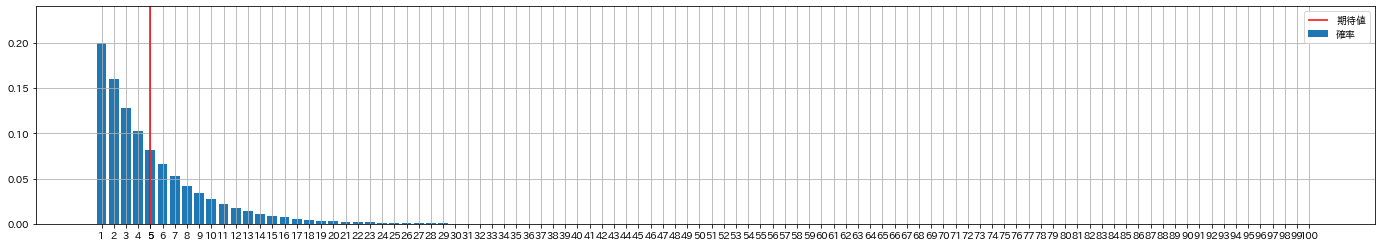

In [ ]:
X = Ge(0.2, x_max=100)
check_prob(X)
plot_prob(X, size=(24, 4))

### SciPyによる実装

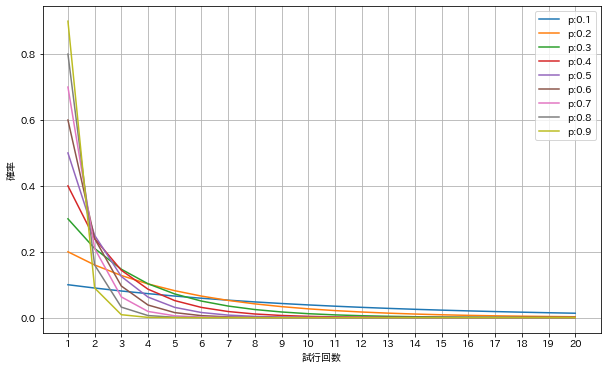

In [ ]:
x_set = np.arange(1, 21)

plt.figure(figsize=(10, 6))
for i in range(1, 10):
    p = i / 10
    
    rv = stats.geom(p)
    prob = rv.pmf(x_set)

    plt.plot(x_set, prob, label=f'p:{p}')
plt.grid(True)
plt.xticks(x_set)
plt.xlabel('試行回数')
plt.ylabel('確率')
plt.legend()
plt.show()

#### 使いどころ

定期購入サービスの解約確率

平均継続月数:7.692


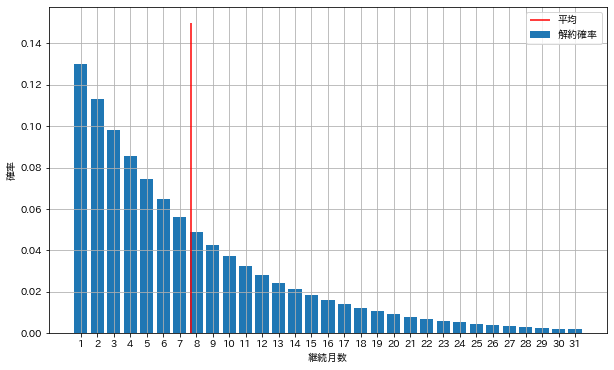

In [ ]:
x_set = np.arange(1, 32)

p = 0.13
rv = stats.geom(p)
pmf = rv.pmf(x_set)
e = rv.mean()
print(f'平均継続月数:{e:.03f}');

plt.figure(figsize=(10, 6))
plt.bar(x_set, pmf, label='解約確率')
plt.vlines(e, 0, 0.15, label='平均', color='red')
plt.grid(True)
plt.xticks(x_set)
plt.xlabel('継続月数')
plt.ylabel('確率')
plt.legend()
plt.show()

### ポアソン分布

#### NumPyによる実装

ポアソン分布の確率変数

In [ ]:
from scipy.special import factorial

def Poi(lam, x_max):
    x_set = np.arange(x_max + 1)
    
    def f(x):
        if x in x_set:
            return np.power(lam, x) / factorial(x) * np.exp(-lam)
        else:
            return 0
    return x_set, f 

ポアソン分布の性質

In [ ]:
lam = 4
X = Poi(4, x_max = 30)

check_prob(X)

期待値: 4.0, 分散: 4.0


ポアソン分布の図示

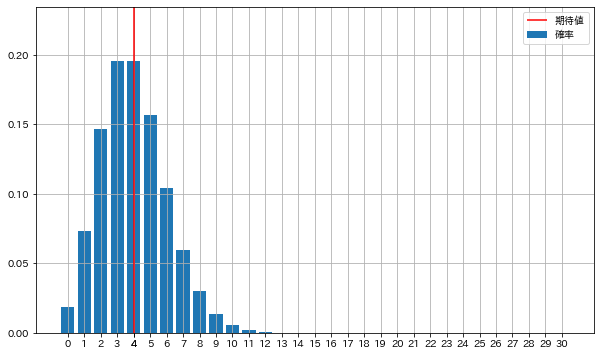

In [ ]:
plot_prob(X)

lamを変化させたときのポアソン分布

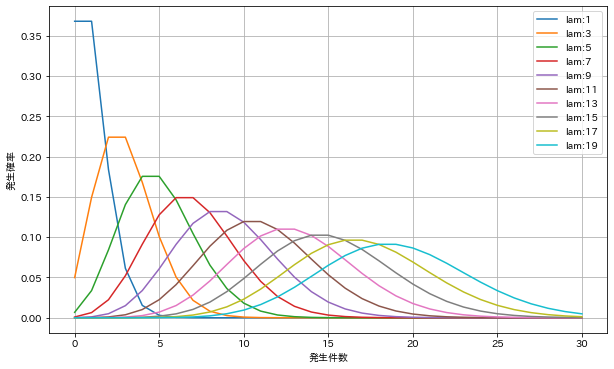

In [ ]:
x_set = np.arange(31)

plt.figure(figsize=(10, 6))
for lam in range(1, 20, 2):
    rv = stats.poisson(lam)
    prob = rv.pmf(x_set)

    plt.plot(x_set, prob, label=f'lam:{lam}')
plt.grid(True)
plt.xlabel('発生件数')
plt.ylabel('発生確率')
plt.legend()
plt.show()

年間で落馬で死亡する人数の確率分布

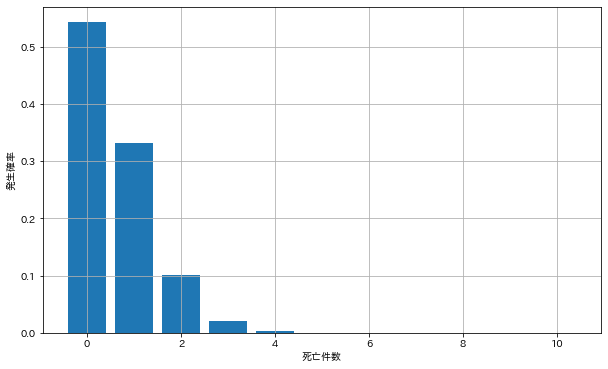

In [ ]:
x_set = np.arange(11)
lam = 0.61

rv = stats.poisson(lam)
prob = rv.pmf(x_set)

plt.figure(figsize=(10, 6))
plt.bar(x_set, prob)
plt.grid(True)
plt.xlabel('死亡件数')
plt.ylabel('発生確率')
plt.show()

コールセンターの１０分間辺りのコール件数

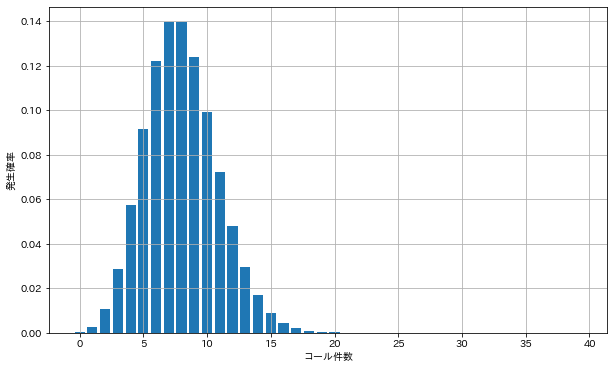

In [ ]:
x_set = np.arange(40)
lam = 8

rv = stats.poisson(lam)
prob = rv.pmf(x_set)

plt.figure(figsize=(10, 6))
plt.bar(x_set, prob)
plt.grid(True)
plt.xlabel('コール件数')
plt.ylabel('発生確率')
plt.show()

コールセンターのキャパシティを検証

In [ ]:
np.sum(prob[17:])

0.0037180212812834303

## 連続型確率変数

## 1次元

### 確率密度関数／密度関数

いかさまルーレットのとりうる値の区間

In [ ]:
x_range = np.array([0, 1])

いかさまルーレットの密度関数

In [ ]:
def f(x):
    x_min, x_max = x_range
    if x_min <= x <= x_max:
        return 2 * x
    else:
        return 0

密度関数と出目が0.5〜0.7になる確率

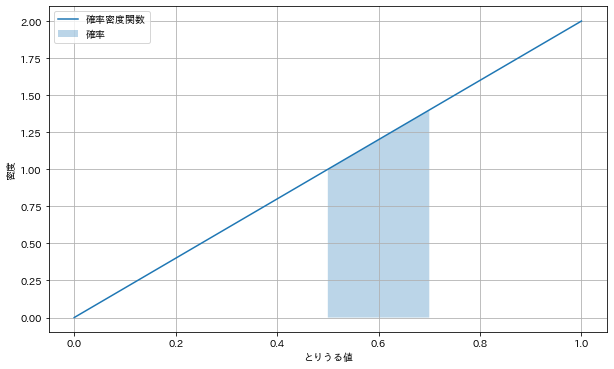

In [ ]:
X = [x_range, f]

x_min, x_max = x_range
x_s = np.linspace(x_min, x_max, 100)

x_fill = np.linspace(0.5, 0.7, 100)

plt.figure(figsize=(10, 6))
plt.plot(x_s, [f(x) for x in x_s], label='確率密度関数')
plt.fill_between(x_fill, [f(x) for x in x_fill], label='確率', alpha=0.3)

plt.grid(True)
plt.xlabel('とりうる値')
plt.ylabel('密度')
plt.legend()
plt.show()

いかさまルーレットの確率分布の面積

In [ ]:
integrate.quad(f, 0.5, 0.7)

(0.240, 0.000)

確率の性質

In [ ]:
f_min = optimize.minimize_scalar(f).fun
f_sum = integrate.quad(f, -np.inf, np.inf)[0]

print(f'最小値: {f_min}')
print(f'総和: {f_sum:.3f}')

最小値: 0
総和: 1.000


### 累積分布関数

In [ ]:
def F(x):
    return integrate.quad(f, -np.inf, x)[0]

F(0.7)

0.490

累積分布関数による区間指定

In [ ]:
F(0.7) - F(0.5)

0.240

いかさまルーレットの累積分布関数の図示

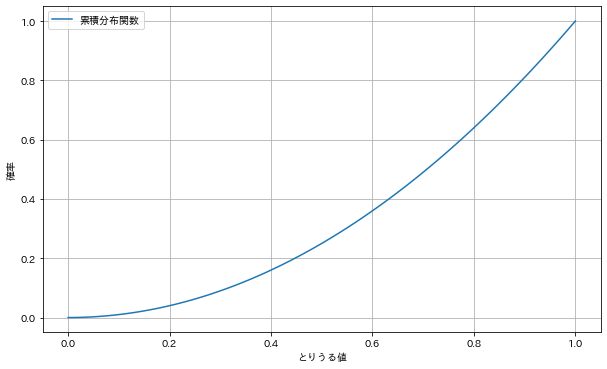

In [ ]:
x_min, x_max = x_range
x_s = np.linspace(x_min, x_max, 100)

plt.figure(figsize=(10, 6))
plt.plot(x_s, [F(x) for x in x_s], label='累積分布関数')

plt.grid(True)
plt.xlabel('とりうる値')
plt.ylabel('確率')
plt.legend()
plt.show()

### 期待値を求める関数

いかさまルーレットの期待値

確率の期待値を求める

In [ ]:
def integrand(x):
    return x * f(x)

integrate.quad(integrand, -np.inf, np.inf)[0]

0.667

期待値を求める関数

In [ ]:
def E(X, g=lambda x: x):
    x_range, f = X

    def integrand(x):
        return g(x) * f(x)
    
    return integrate.quad(integrand, -np.inf, np.inf)[0]

E(X)

0.667

確率変数の変換

In [ ]:
E(X, g=lambda x: 5 * x - 3)

0.333

期待値の線形性

In [ ]:
5 * E(X) - 3

0.333

分散

分散を求める関数

In [ ]:
def V(X, g=lambda x: x):
    x_range, f = X
    mean = E(X, g)

    def integrand(x):
        return (g(x) - mean) ** 2 * f(x)
    
    return integrate.quad(integrand, -np.inf, np.inf)[0]

V(X)

0.056

確率変数の変換

In [ ]:
V(X, g=lambda x: 5 * x - 3)

1.389

分散の公式

In [ ]:
5 ** 2 * V(X)

1.389

## 2次元

### 同時確率密度関数

とりうる値の定義

In [ ]:
x_range = [0, 2]
y_range = [0, 1]

同時確率密度関数の実装

In [ ]:
def f_xy(x, y):
    if 0 <= y <= 1 and 0 <= x - y <= 1:
        return 4 * y * (x - y)
    else:
        return 0

2次元の確率変数

In [ ]:
XY = [x_range, y_range, f_xy]
XY

[[0, 2], [0, 1], <function __main__.f_xy(x, y)>]

確率密度の分布

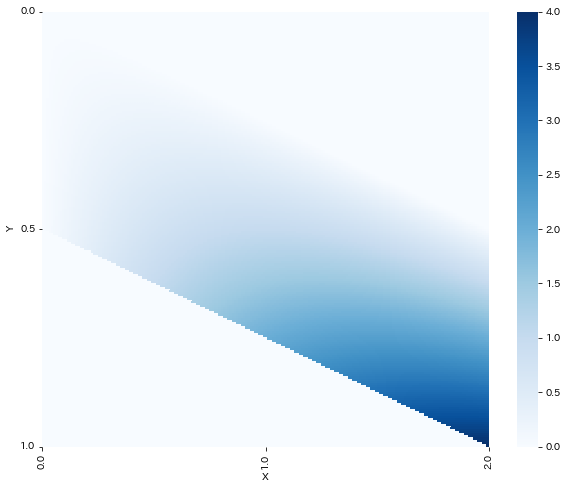

In [ ]:
xr = np.linspace(x_range[0], x_range[1], 200)
yr = np.linspace(y_range[0], y_range[1], 200)
pd_xy = np.array([[f_xy(x, y) for y in yr] for x in xr])

plt.figure(figsize=(10, 8))
sns.heatmap(
    pd_xy, xticklabels=np.linspace(0, 2, 3), yticklabels=np.linspace(0, 1, 3),
    cmap='Blues')
plt.xticks(np.linspace(0, 200, 3))
plt.yticks(np.linspace(0, 200, 3))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

2次元の確率の総和

In [ ]:
integrate.nquad(f_xy, [[-np.inf, np.inf], [-np.inf, np.inf]])[0]

1.000

### 周辺確率密度関数

周辺密度関数の定義

In [ ]:
def f_X(x):
    return integrate.quad(partial(f_xy, x), -np.inf, np.inf)[0]

def f_Y(y):
    return integrate.quad(partial(f_xy, ｙ=y), -np.inf, np.inf)[0]

XとYそれぞれの周辺密度関数の図示

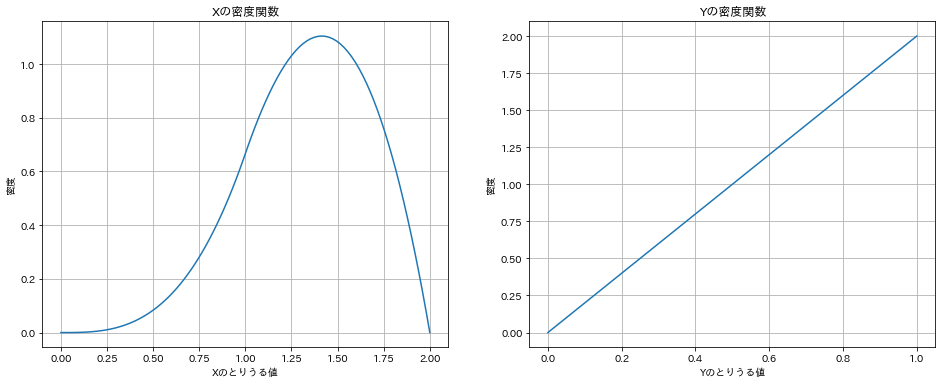

In [ ]:
X = [x_range, f_X]
Y = [y_range, f_Y]

xr = np.linspace(x_range[0], x_range[1], 100)
yr = np.linspace(y_range[0], y_range[1], 100)

prob_x = [f_X(x) for x in xr]
prob_y = [f_Y(y) for y in yr]

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(xr, prob_x)
ax1.set_title('Xの密度関数')
ax1.set_xlabel('Xのとりうる値')
ax1.set_ylabel('密度')
ax1.grid()

ax2.plot(yr, prob_y)
ax2.set_title('Yの密度関数')
ax2.set_xlabel('Yのとりうる値')
ax2.set_ylabel('密度')
ax2.grid()

plt.show()

### 期待値

2次元の連続型確率変数の期待値

In [ ]:
def E2(XY, g):
    x_range, y_range, f_xy = XY
    
    def integrand(x, y):
        return g(x, y) * f_xy(x, y)
    
    return integrate.nquad(integrand, [[-np.inf, np.inf], [-np.inf, np.inf]])[0]

mean_X = E2(XY, lambda x, y: x)
mean_Y = E2(XY, lambda x, y: y)
mean_X, mean_Y

(1.333, 0.667)

期待値の線形性

In [ ]:
a, b = 2, 3

E2(XY, lambda x, y: (a * x) + (b * y)), (a * mean_X) + (b * mean_Y)

(4.667, 4.667)

### 分散

In [ ]:
def V2(XY, g):
    x_range, y_range, f_xy = XY
    mean = E2(XY, g)
    
    def integrand(x, y):
        return (g(x, y) - mean) ** 2 * f_xy(x, y)
    
    return integrate.nquad(integrand, [[-np.inf, np.inf], [-np.inf, np.inf]])[0]

var_X = V2(XY, lambda x, y: x)
var_Y = V2(XY, lambda x, y: y)
var_X, var_Y

(0.111, 0.056)

### 共分散

In [ ]:
def cov(XY):
    x_range, y_range, f_xy = XY
    mean_X = E2(XY, lambda x, y: x)
    mean_Y = E2(XY, lambda x, y: y)
    
    def integrand(x, y):
        return (x - mean_X) * (y - mean_Y) * f_xy(x, y)
    
    return integrate.nquad(integrand, [[-np.inf, np.inf], [-np.inf, np.inf]])[0]

cov_XY = cov(XY)
cov_XY

0.056

### 相関係数

In [ ]:
cov_XY / np.sqrt(var_X * var_Y)

0.7071117041227913